In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import numpy as np
import os
import cv2
from torchvision import models
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
# 超参数设置
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_CLASSES = 7
EPOCHS = 30
LEARNING_RATE = 0.001

# 初始化记录容器
train_loss_history = []
val_loss_history = []
val_acc_history = []

# 设备配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据文件夹路径
train_dir = "./Training"
validation_dir = "./PublicTest"

In [3]:
import torch
import torch.nn as nn
import timm
from torchvision.models import resnet18
from einops import rearrange

class ResNet18_ViT(nn.Module):
    def __init__(self, num_classes=7):  # FER2013 有 7 类情绪
        super(ResNet18_ViT, self).__init__()
        
        # ResNet18
        resnet = resnet18(pretrained=True)
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-2])  # removes the last global average pooling layer and the fully connected layer
        
        # ViT
        self.vit = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=num_classes)

        # Adapt ResNet18 output to ViT
        self.conv1x1 = nn.Conv2d(512, 3, kernel_size=1)

    def forward(self, x):
        x = self.resnet_features(x)  # Extract features through ResNet18
        x = self.conv1x1(x)  # Adjust the number of channels
        x = torch.nn.functional.interpolate(x, size=(224, 224), mode='bilinear')  # Adapt ViT input
        x = self.vit(x)  # ViT Classification
        return x

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18_ViT(num_classes=7).to(device)

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)  # 余弦退火学习率调度器

D:\Anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# 定义数据增强和预处理
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),           # 随机水平翻转
    transforms.RandomRotation(10),              # 随机旋转
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # 随机平移
    transforms.ToTensor(),                      # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

validation_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 创建数据集
train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
validation_dataset = ImageFolder(root=validation_dir, transform=validation_transforms)

# 创建DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 检查数据集是否正确加载
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(validation_dataset)}")

Number of training samples: 25337
Number of validation samples: 3589


In [6]:
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

        train_losses.append(train_loss / len(train_loader))
        train_accs.append(100 * correct / total)

        # 验证
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(100 * correct / total)

        print(f"Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.2f}%")

    return train_losses, val_losses, train_accs, val_accs


In [14]:
epochs = 30
train_losses, val_losses, train_accs, val_accs = train(model, train_loader, val_loader, criterion, optimizer, device, epochs)
torch.save(model, "mixed_myself.pt")

Epoch 1/30: 100%|██████████| 396/396 [02:19<00:00,  2.84it/s, acc=51.5, loss=1.13] 


Epoch 1: Train Loss: 1.2249, Train Acc: 51.54%, Val Loss: 1.4464, Val Acc: 50.99%


Epoch 2/30: 100%|██████████| 396/396 [02:15<00:00,  2.92it/s, acc=61.6, loss=0.989]


Epoch 2: Train Loss: 1.0110, Train Acc: 61.56%, Val Loss: 1.3818, Val Acc: 54.08%


Epoch 3/30: 100%|██████████| 396/396 [02:15<00:00,  2.92it/s, acc=65.3, loss=0.766]


Epoch 3: Train Loss: 0.9210, Train Acc: 65.31%, Val Loss: 1.2995, Val Acc: 56.51%


Epoch 4/30: 100%|██████████| 396/396 [02:16<00:00,  2.91it/s, acc=67.8, loss=0.956]


Epoch 4: Train Loss: 0.8575, Train Acc: 67.75%, Val Loss: 1.2253, Val Acc: 58.07%


Epoch 5/30: 100%|██████████| 396/396 [02:15<00:00,  2.92it/s, acc=70.6, loss=0.84] 


Epoch 5: Train Loss: 0.7957, Train Acc: 70.61%, Val Loss: 1.3470, Val Acc: 56.87%


Epoch 6/30: 100%|██████████| 396/396 [02:15<00:00,  2.92it/s, acc=72.7, loss=0.735]


Epoch 6: Train Loss: 0.7441, Train Acc: 72.71%, Val Loss: 1.1869, Val Acc: 59.21%


Epoch 7/30: 100%|██████████| 396/396 [02:15<00:00,  2.92it/s, acc=74.4, loss=0.939]


Epoch 7: Train Loss: 0.6921, Train Acc: 74.41%, Val Loss: 1.2496, Val Acc: 59.32%


Epoch 8/30: 100%|██████████| 396/396 [02:15<00:00,  2.92it/s, acc=76.7, loss=0.557]


Epoch 8: Train Loss: 0.6363, Train Acc: 76.66%, Val Loss: 1.3811, Val Acc: 58.46%


Epoch 9/30: 100%|██████████| 396/396 [02:16<00:00,  2.91it/s, acc=78.5, loss=0.59] 


Epoch 9: Train Loss: 0.5910, Train Acc: 78.46%, Val Loss: 1.3822, Val Acc: 58.18%


Epoch 10/30: 100%|██████████| 396/396 [02:15<00:00,  2.92it/s, acc=80.1, loss=0.405]


Epoch 10: Train Loss: 0.5520, Train Acc: 80.13%, Val Loss: 1.3504, Val Acc: 59.79%


Epoch 11/30: 100%|██████████| 396/396 [02:15<00:00,  2.92it/s, acc=82.1, loss=0.658]


Epoch 11: Train Loss: 0.5050, Train Acc: 82.06%, Val Loss: 1.4985, Val Acc: 59.13%


Epoch 12/30: 100%|██████████| 396/396 [02:15<00:00,  2.92it/s, acc=83.1, loss=0.487]


Epoch 12: Train Loss: 0.4704, Train Acc: 83.07%, Val Loss: 1.3424, Val Acc: 61.35%


Epoch 13/30: 100%|██████████| 396/396 [02:15<00:00,  2.93it/s, acc=84.7, loss=0.396]


Epoch 13: Train Loss: 0.4305, Train Acc: 84.71%, Val Loss: 1.4631, Val Acc: 60.07%


Epoch 14/30: 100%|██████████| 396/396 [02:15<00:00,  2.92it/s, acc=86, loss=0.4]    


Epoch 14: Train Loss: 0.3957, Train Acc: 86.02%, Val Loss: 1.4458, Val Acc: 61.02%


Epoch 15/30: 100%|██████████| 396/396 [02:15<00:00,  2.92it/s, acc=87.3, loss=0.505]


Epoch 15: Train Loss: 0.3594, Train Acc: 87.29%, Val Loss: 1.3402, Val Acc: 62.83%


Epoch 16/30: 100%|██████████| 396/396 [02:15<00:00,  2.92it/s, acc=88.7, loss=0.265] 


Epoch 16: Train Loss: 0.3217, Train Acc: 88.72%, Val Loss: 1.5444, Val Acc: 60.94%


Epoch 17/30: 100%|██████████| 396/396 [02:15<00:00,  2.92it/s, acc=89.5, loss=0.302]


Epoch 17: Train Loss: 0.2980, Train Acc: 89.47%, Val Loss: 1.5781, Val Acc: 62.58%


Epoch 18/30: 100%|██████████| 396/396 [02:15<00:00,  2.93it/s, acc=90.3, loss=0.334]


Epoch 18: Train Loss: 0.2776, Train Acc: 90.28%, Val Loss: 1.5763, Val Acc: 62.91%


Epoch 19/30: 100%|██████████| 396/396 [02:15<00:00,  2.92it/s, acc=90.7, loss=0.117] 


Epoch 19: Train Loss: 0.2608, Train Acc: 90.67%, Val Loss: 1.6722, Val Acc: 61.13%


Epoch 20/30: 100%|██████████| 396/396 [02:15<00:00,  2.92it/s, acc=91.5, loss=0.534] 


Epoch 20: Train Loss: 0.2422, Train Acc: 91.46%, Val Loss: 1.6623, Val Acc: 61.83%


Epoch 21/30: 100%|██████████| 396/396 [02:15<00:00,  2.92it/s, acc=92.3, loss=0.174] 


Epoch 21: Train Loss: 0.2223, Train Acc: 92.28%, Val Loss: 1.8807, Val Acc: 60.27%


Epoch 22/30: 100%|██████████| 396/396 [02:15<00:00,  2.92it/s, acc=92.6, loss=0.403] 


Epoch 22: Train Loss: 0.2071, Train Acc: 92.57%, Val Loss: 1.6816, Val Acc: 63.81%


Epoch 23/30: 100%|██████████| 396/396 [02:15<00:00,  2.93it/s, acc=93.3, loss=0.32]  


Epoch 23: Train Loss: 0.1932, Train Acc: 93.29%, Val Loss: 1.6623, Val Acc: 62.83%


Epoch 24/30: 100%|██████████| 396/396 [02:15<00:00,  2.92it/s, acc=93.6, loss=0.0821]


Epoch 24: Train Loss: 0.1877, Train Acc: 93.59%, Val Loss: 1.6932, Val Acc: 62.08%


Epoch 25/30: 100%|██████████| 396/396 [02:15<00:00,  2.92it/s, acc=93.9, loss=0.136] 


Epoch 25: Train Loss: 0.1773, Train Acc: 93.85%, Val Loss: 1.9310, Val Acc: 60.57%


Epoch 26/30: 100%|██████████| 396/396 [02:15<00:00,  2.93it/s, acc=94.1, loss=0.219] 


Epoch 26: Train Loss: 0.1694, Train Acc: 94.07%, Val Loss: 1.6653, Val Acc: 64.20%


Epoch 27/30: 100%|██████████| 396/396 [02:15<00:00,  2.93it/s, acc=94.3, loss=0.144] 


Epoch 27: Train Loss: 0.1620, Train Acc: 94.35%, Val Loss: 1.9553, Val Acc: 61.44%


Epoch 28/30: 100%|██████████| 396/396 [02:14<00:00,  2.93it/s, acc=94.7, loss=0.27]  


Epoch 28: Train Loss: 0.1547, Train Acc: 94.71%, Val Loss: 1.7649, Val Acc: 62.02%


Epoch 29/30: 100%|██████████| 396/396 [02:15<00:00,  2.93it/s, acc=94.8, loss=0.256] 


Epoch 29: Train Loss: 0.1458, Train Acc: 94.80%, Val Loss: 2.0011, Val Acc: 62.52%


Epoch 30/30: 100%|██████████| 396/396 [02:15<00:00,  2.93it/s, acc=95, loss=0.363]   


Epoch 30: Train Loss: 0.1455, Train Acc: 94.99%, Val Loss: 1.7865, Val Acc: 63.14%


In [40]:
print(torch.cuda.is_available())  # 应该输出 True
print(torch.cuda.device_count())  # 应该大于 0
print(torch.cuda.get_device_name(0))  # 检查 GPU 名称

True
1
NVIDIA GeForce RTX 4060 Laptop GPU


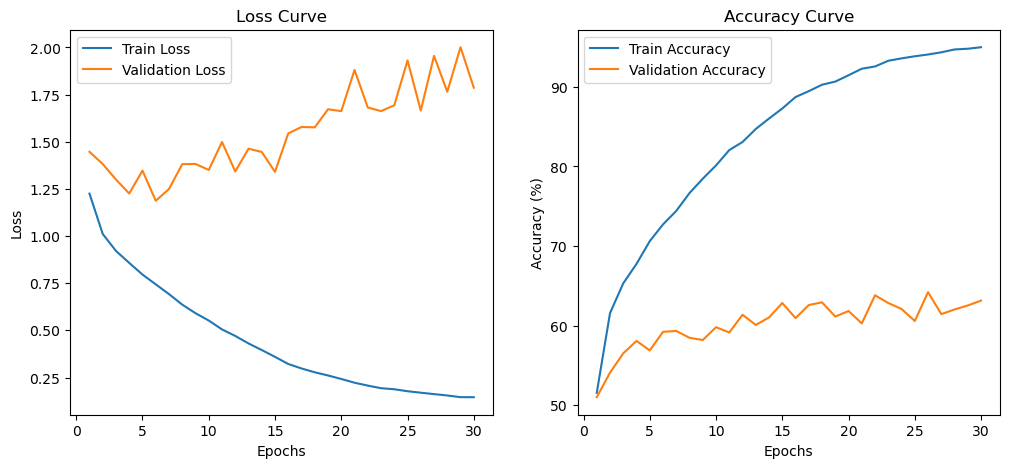

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accs, label="Train Accuracy")
plt.plot(range(1, epochs+1), val_accs, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy Curve")

plt.show()

In [21]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import numpy as np
import os
import cv2
from torchvision import models
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# 确保你的设备是 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

BATCH_SIZE = 64

test_dir = "./PrivateTest"

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder(root=test_dir, transform=test_transforms)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of test samples: {len(test_dataset)}")

Using device: cuda
Number of test samples: 3589


C:\Users\HE\AppData\Local\Temp\ipykernel_12924\1434820079.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("mixed_myself.pt")


Test Accuracy: 64.14%
Confusion Matrix:
 [[287  16  77  14  41  54   2]
 [  5  43   4   1   1   1   0]
 [ 57   7 328  14  47  70   5]
 [ 10   2  18 801  25  21   2]
 [ 33   2  42  37 430  80   2]
 [ 51   9  86  30  98 320   0]
 [ 25   1 169  57  49  22  93]]


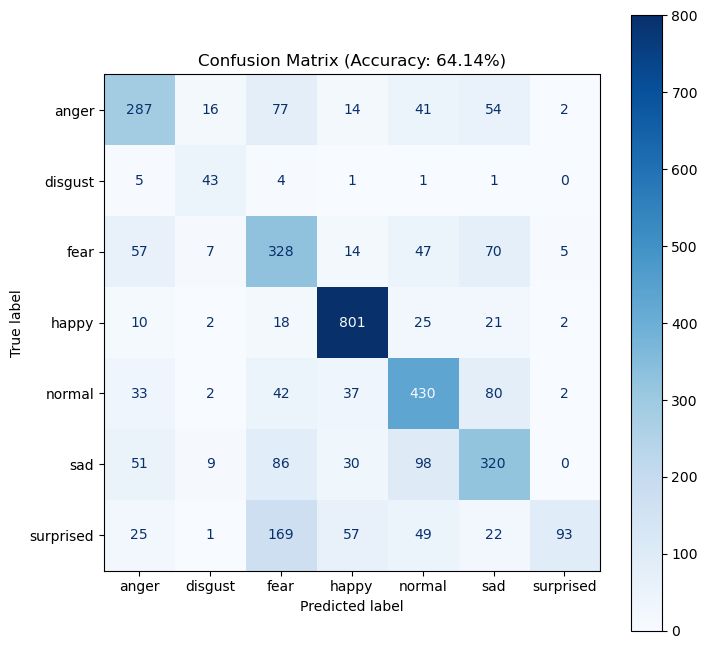

In [22]:
# 定义模型结构（与保存权重时一致）
model = torch.load("mixed_myself.pt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()  # 切换到评估模式

# 初始化真实标签和预测标签
all_labels = []
all_preds = []

# 模型测试并记录标签
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 计算准确率
accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")

# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# 绘制混淆矩阵
labels = test_dataset.classes  # 获取类别名称
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
plt.title(f"Confusion Matrix (Accuracy: {accuracy:.2f}%)")
plt.show()